In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.distributions as dist
import torch
import copy
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from scripts.utils import ScaleData, train_keys
from scripts.AutoEncoder import AutoEncoderDataset
from tqdm import tqdm

import itertools
import seaborn as sns
#%matplotlib notebook
from tqdm.auto import tqdm

In [2]:
# do we have a gpu 
gpu = torch.cuda.is_available()

if gpu:
    device = torch.cuda.current_device()
    print(f'GPU device: {device}')
else: 
    print('No GPU')

GPU device: 0


In [3]:
torch.cuda.device_count()

1

In [4]:
train_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
train_data = AutoEncoderDataset(train_data_path, columns = train_keys, train = True)
n = 500_000
train_data.data = train_data.data.sample(n)
train_data.scale()

train_loader = DataLoader(train_data, shuffle = True, batch_size = 2048)

# valid_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl"
# valid_data = AutoEncoderDataset(valid_data_path, columns = train_keys, train = True)
# # valid_data.data = valid_data.data.sample(100_000)
# valid_data.scale()

# valid_loader = DataLoader(valid_data, shuffle = True, batch_size = 2048)

In [5]:
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl"

df_test = pd.read_pickle(test)
df_test = df_test.sample(10_000)
target = df_test['target']
df_test_good = df_test[df_test.target == 1]
df_test_good = df_test_good[train_keys]

df_test_good,_ = ScaleData(df_test_good)

df_test_bad = df_test[df_test.target == 0]
df_test_bad = df_test_bad[train_keys]
df_test_bad,_ = ScaleData(df_test_bad)

df_test_good.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03,6.662000e+03
mean,7.514462e-17,-7.833805e-17,6.326038e-17,2.558746e-16,-2.308604e-16,1.134554e-16,5.994404e-17,-1.391528e-18,7.682570e-18,-5.020335e-17,7.890883e-18,2.955748e-17,-2.061462e-17,-2.289939e-16,-5.532784e-18
std,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00
min,-8.246319e+00,-4.834005e+00,-1.683633e+01,-2.003776e+00,-1.405803e+00,-1.289087e+00,-1.600047e+01,-1.177809e+00,-2.048813e+00,-1.339634e+00,-1.456247e+01,-6.922448e+00,-1.740265e+00,-3.086787e+00,-2.614868e+00
25%,-3.998261e-01,-5.652019e-01,-2.866524e-01,-5.289648e-01,-9.503429e-01,-7.924778e-01,5.362704e-02,-7.297155e-01,-6.452027e-01,-4.664775e-01,-3.376382e-01,-5.703632e-01,-2.591979e-01,-9.937517e-02,-7.325699e-01
50%,-1.987239e-01,-2.718186e-01,-2.866524e-01,-5.289648e-01,-1.469086e-01,-1.459247e-01,5.362704e-02,-2.951385e-01,-3.984473e-01,-3.317653e-01,-1.895628e-01,-2.535986e-01,-2.113275e-01,-9.937517e-02,-1.380538e-01
75%,9.249870e-02,1.904012e-01,-3.572610e-02,1.382456e-01,9.423925e-01,4.942120e-01,5.362704e-02,4.270559e-01,2.751255e-01,6.800283e-02,3.533291e-02,2.865737e-01,-1.009471e-01,-9.937517e-02,5.875904e-01
max,1.209957e+01,9.578633e+00,1.764753e+01,5.252982e+00,1.657479e+00,1.493632e+01,1.275081e+01,9.284174e+00,6.405865e+00,1.334339e+01,1.356769e+01,9.439807e+00,1.732922e+01,2.001491e+01,5.683631e+00


In [6]:
data_good = torch.from_numpy(df_test_good.values).float()
data_bad = torch.from_numpy(df_test_bad.values).float()
#data_good_batch = next(iter(data_good_loader))
# with torch.no_grad():
#     outputs_good = encoder.forward(data_good).sample()
#     outputs_bad = encoder.forward(data_bad).sample()
# #    outputs_good = encoder.forward(data_good).sample().detach().numpy()
    
# plt.figure()
# plt.scatter(outputs_good[:,0], outputs_good[:,1])
# plt.scatter(outputs_bad[:,0], outputs_bad[:,1])

### Alternative VAE Implemention

In [7]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(15, 150)
        self.linear2 = nn.Linear(150, 75)
        self.linear3 = nn.Linear(75, 30)
        self.linear4 = nn.Linear(30, 15)
        
        self.mu = nn.Linear(15, latent_dims)
        self.logvar = nn.Linear(15, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.float()
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        
        mu =  self.mu(x)
        sigma = torch.exp(self.logvar(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [8]:
class VariationalDecoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 15)
        self.linear2 = nn.Linear(15, 30)
        self.linear3 = nn.Linear(30, 75)
        self.linear4 = nn.Linear(75, 150)
        self.linear5 = nn.Linear(150,15)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = F.relu(self.linear3(z))
        z = F.relu(self.linear4(z))
        z = self.linear5(z)
        return z

In [9]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [10]:
def train(autoencoder, data, epochs=50):
    opt = torch.optim.Adam(autoencoder.parameters(), lr =lr)
    
    for epoch in range(epochs):
        running_loss = 0
        for i, x in enumerate(tqdm(data, desc=f'Epoch {epoch}')):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            running_loss += loss.item()
            opt.step()
        print(f'Loss: {np.mean(running_loss/n):.3f}')
    return autoencoder

In [11]:
lr = 1e-3
latent_dims = 3
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, train_loader)

Epoch 0:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 15.628


Epoch 1:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 13.701


Epoch 2:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 13.394


Epoch 3:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 13.000


Epoch 4:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 12.669


Epoch 5:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 12.528


Epoch 6:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 12.071


Epoch 7:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 11.667


Epoch 8:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 11.254


Epoch 9:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 10.973


Epoch 10:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 10.846


Epoch 11:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 10.510


Epoch 12:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 10.219


Epoch 13:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 10.161


Epoch 14:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 10.275


Epoch 15:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 10.027


Epoch 16:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 9.787


Epoch 17:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 9.598


Epoch 18:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 9.575


Epoch 19:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 9.455


Epoch 20:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 9.397


Epoch 21:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 9.181


Epoch 22:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 9.017


Epoch 23:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.930


Epoch 24:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.887


Epoch 25:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.758


Epoch 26:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.633


Epoch 27:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.528


Epoch 28:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.461


Epoch 29:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.377


Epoch 30:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.405


Epoch 31:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.420


Epoch 32:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.443


Epoch 33:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.416


Epoch 34:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.354


Epoch 35:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.368


Epoch 36:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.321


Epoch 37:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.331


Epoch 38:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.262


Epoch 39:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.413


Epoch 40:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.569


Epoch 41:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.424


Epoch 42:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.325


Epoch 43:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.272


Epoch 44:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.114


Epoch 45:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.320


Epoch 46:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.443


Epoch 47:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.153


Epoch 48:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.087


Epoch 49:   0%|          | 0/245 [00:00<?, ?it/s]

Loss: 8.059


In [12]:
vae.cuda()
good_data = data_good.cuda()
AE_output2 = vae(good_data)

AE_output2 = AE_output2.to('cpu')
AE_output2 = AE_output2.detach().numpy()
df_ae_output2 = pd.DataFrame(AE_output2, columns = train_keys)
df_ae_output2['AE'] = 'Outputs'

df_test_tmp = df_test_good
df_test_tmp['AE'] = 'Inputs'

df_compare2 = pd.concat([df_ae_output2, df_test_tmp], ignore_index=True)
df_compare_sample2= df_compare2.sample(10_000)

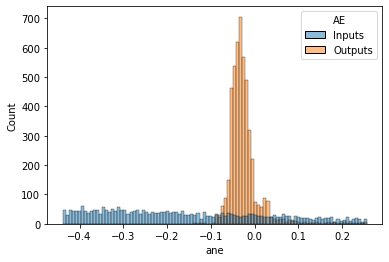

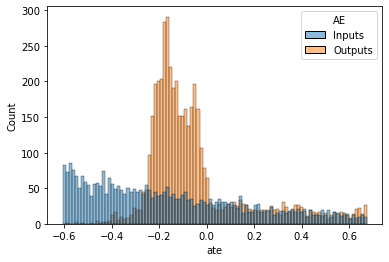

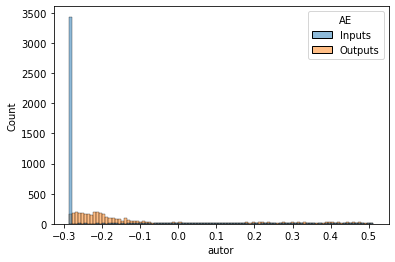

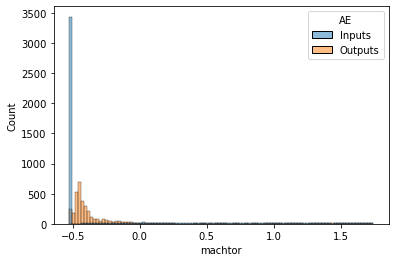

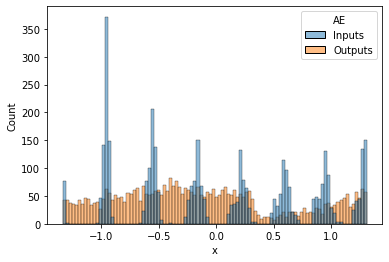

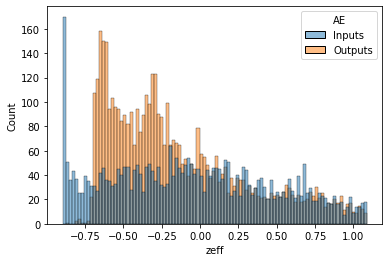

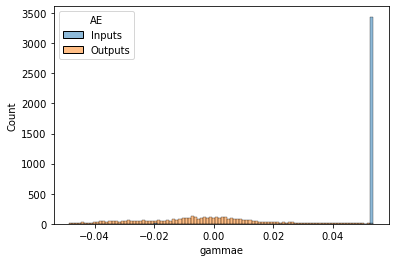

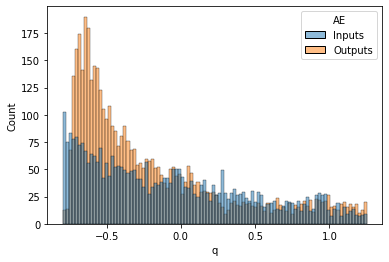

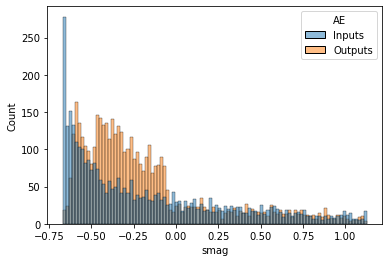

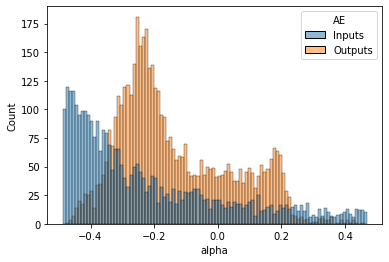

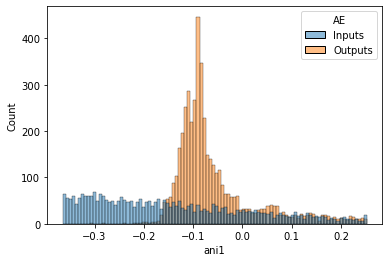

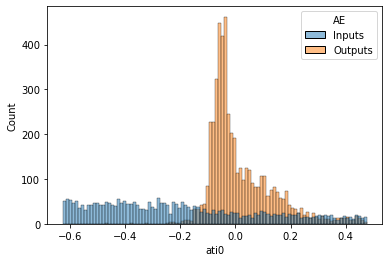

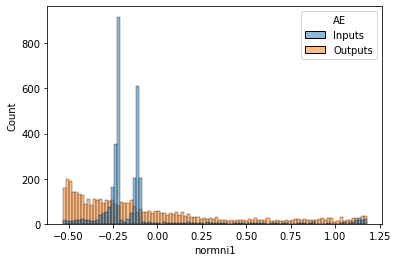

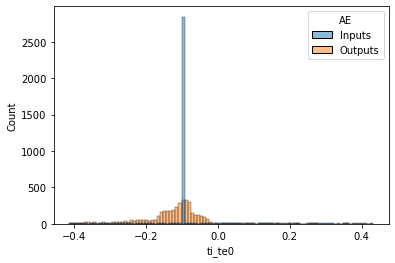

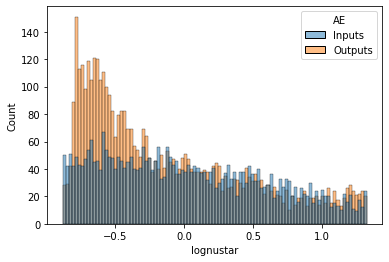

In [13]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample2[i].quantile(0.1)
    x_max = df_compare_sample2[i].quantile(0.9)
    sns.histplot(data = df_compare_sample2, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)